## 1. Autoencoder

In [1]:
from keras import layers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
import numpy as np
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt

In [2]:
# Prepare the auto encoder
input_img = Input(shape=(32, 32, 3))

x = layers.Conv2D(16, (2, 2), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((6, 6), padding='same')(x)
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((1, 1))(x)
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(x)
x = layers.UpSampling2D((11, 11))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='softmax', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 8)           520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 8)           264       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 8)          

In [8]:
# loading the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [9]:
autoencoder.fit(x_train[0:1000], x_train[0:1000],
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test[0:200], x_test[0:200]))

Epoch 1/10
8/8 [==============================] - 1s 169ms/step - loss: 82.3348 - val_loss: 83.8897
Epoch 2/10
8/8 [==============================] - 1s 175ms/step - loss: 82.2660 - val_loss: 83.8485
Epoch 3/10
8/8 [==============================] - 1s 174ms/step - loss: 82.1873 - val_loss: 83.8116
Epoch 4/10
8/8 [==============================] - 2s 222ms/step - loss: 82.1328 - val_loss: 83.7860
Epoch 5/10
8/8 [==============================] - 1s 165ms/step - loss: 82.0677 - val_loss: 83.7372
Epoch 6/10
8/8 [==============================] - 1s 156ms/step - loss: 82.0046 - val_loss: 83.7047
Epoch 7/10
8/8 [==============================] - 2s 206ms/step - loss: 81.9444 - val_loss: 83.7025
Epoch 8/10
8/8 [==============================] - 1s 160ms/step - loss: 81.8826 - val_loss: 83.6609
Epoch 9/10
8/8 [==============================] - 1s 170ms/step - loss: 81.8403 - val_loss: 83.6646
Epoch 10/10
8/8 [==============================] - 1s 180ms/step - loss: 81.7547 - val_loss: 83.5837

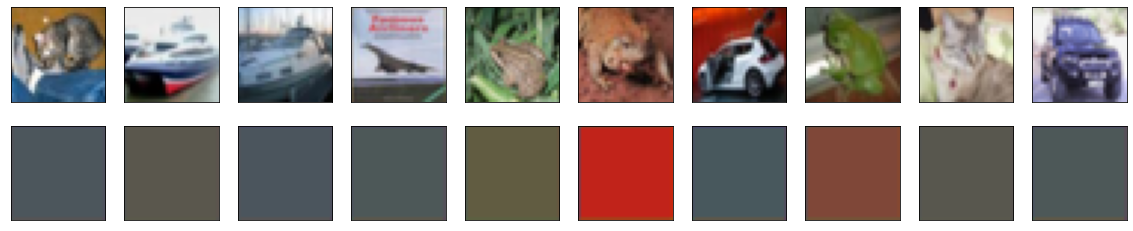

In [10]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

* I tried to tune the parameters and add/delete layers several times but the results are not ideal. From the decoded images, you can only tell the the main color theme of the original images.

## 2. Image Classification

### 2.1 Deep CNN

* I chose to have 3 Conv2D layers and all their kernel size are 3 by 3, strides are 1 by 1 with same paddings.
* Also I have 2 MaxPool2D layers and Dropout layers for regularization.
* I use softmax as the output function and relu as the activation functions
* Categoriacal cross entropy as the loss function
* The model reachs a highest accuracy of 0.3742 on validation dataset, the accuracy is increasing as the training processing.

In [21]:
# loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# # building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [22]:
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

model = Sequential()

#convolutional layers
model.add(layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

model.add(layers.Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

# hidden layer
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dropout(0.3))

# output layer
model.add(layers.Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 50)        1400      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 75)        33825     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 75)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 125)       84500     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 125)        

In [25]:
# training the model for 10 epochs
model.fit(X_train[0:1000], Y_train[0:1000], batch_size=128, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
8/8 [==============================] - 26s 3s/step - loss: 1.7496 - accuracy: 0.3400 - val_loss: 1.7892 - val_accuracy: 0.3529
Epoch 2/10
8/8 [==============================] - 32s 4s/step - loss: 1.6547 - accuracy: 0.3800 - val_loss: 1.6912 - val_accuracy: 0.3883
Epoch 3/10
8/8 [==============================] - 35s 4s/step - loss: 1.5849 - accuracy: 0.4170 - val_loss: 1.6449 - val_accuracy: 0.4010
Epoch 4/10
8/8 [==============================] - 37s 5s/step - loss: 1.5216 - accuracy: 0.4270 - val_loss: 1.8258 - val_accuracy: 0.3447
Epoch 5/10
8/8 [==============================] - 32s 4s/step - loss: 1.5493 - accuracy: 0.4350 - val_loss: 1.7070 - val_accuracy: 0.3767
Epoch 6/10
8/8 [==============================] - 31s 4s/step - loss: 1.4217 - accuracy: 0.4780 - val_loss: 1.6175 - val_accuracy: 0.4136
Epoch 7/10
8/8 [==============================] - 36s 4s/step - loss: 1.3632 - accuracy: 0.5020 - val_loss: 1.6670 - val_accuracy: 0.3979
Epoch 8/10
8/8 [==================

### 2.2 Transfer Learning

I chose VGG19 as the base model

In [118]:
base_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

80142336/80134624 [==============================] - 2s 0us/step


we need train, test and validation dataset

In [122]:
from sklearn.model_selection import train_test_split

In [125]:
model= Sequential()
model.add(base_model)
model.add(layers.Flatten())

In [126]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.add(layers.Dense(1024,activation=('relu'),input_dim=512))
model.add(layers.Dense(512,activation=('relu'))) 
model.add(layers.Dense(256,activation=('relu'))) 
model.add(layers.Dense(128,activation=('relu')))
model.add(layers.Dense(10,activation=('softmax')))

choose "adam" as the optimizer

In [134]:
#adam=Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [135]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [138]:
# training the model for 10 epochs
model.fit(X_train[0:1000], Y_train[0:1000], batch_size=128, epochs=10, validation_data=(X_test[0:200], Y_test[0:200]))

Train on 1000 samples, validate on 200 samples
Epoch 1/10
1000/1000 [==============================] - 54s 54ms/step - loss: 2.3809 - accuracy: 0.0930 - val_loss: 2.3302 - val_accuracy: 0.0700
Epoch 2/10
1000/1000 [==============================] - 57s 57ms/step - loss: 2.3504 - accuracy: 0.1130 - val_loss: 2.3783 - val_accuracy: 0.1000
Epoch 3/10
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3254 - accuracy: 0.0970 - val_loss: 2.3152 - val_accuracy: 0.0750
Epoch 4/10
1000/1000 [==============================] - 65s 65ms/step - loss: 2.3075 - accuracy: 0.1000 - val_loss: 2.2992 - val_accuracy: 0.1300
Epoch 5/10
1000/1000 [==============================] - 78s 78ms/step - loss: 2.3058 - accuracy: 0.1130 - val_loss: 2.3147 - val_accuracy: 0.0700
Epoch 6/10
1000/1000 [==============================] - 83s 83ms/step - loss: 2.3031 - accuracy: 0.1120 - val_loss: 2.3048 - val_accuracy: 0.0700
Epoch 7/10
1000/1000 [==============================] - 90s 90ms/step - loss:

## 3. Text Classification

In [27]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc

In [28]:
file_name = "SPAM_detection.csv"
df = pd.read_csv(file_name)
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### 3.1 RNN

In [44]:
# LSTM Modeling

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

# Prepare X
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# Prepare Y
Y = df['category_val']
Y = np.array(Y).reshape(len(Y), 1)

# train, test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(f"X train: {X_train.shape}, Y train: {Y_train.shape}")
print(f"X test: {X_test.shape}, Y test: {Y_test.shape}")

Found 9006 unique tokens.
Shape of data tensor: (5572, 250)
X train: (5014, 250), Y train: (5014, 1)
X test: (558, 250), Y test: (558, 1)


In [45]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2)) # performs variational dropout in NLP models
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer with 100 memory units
model.add(Dense(1, activation='relu')) # output layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                   validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
71/71 [==============================] - 73s 1s/step - loss: 0.3947 - accuracy: 0.9286 - val_loss: 0.2050 - val_accuracy: 0.9741
Epoch 2/5
71/71 [==============================] - 67s 938ms/step - loss: 0.0724 - accuracy: 0.9883 - val_loss: 0.1041 - val_accuracy: 0.9841
Epoch 3/5
71/71 [==============================] - 62s 867ms/step - loss: 0.0411 - accuracy: 0.9947 - val_loss: 0.1490 - val_accuracy: 0.9801
Epoch 4/5
71/71 [==============================] - 66s 930ms/step - loss: 0.0314 - accuracy: 0.9967 - val_loss: 0.1274 - val_accuracy: 0.9781
Epoch 5/5
71/71 [==============================] - 60s 849ms/step - loss: 0.0258 - accuracy: 0.9980 - val_loss: 0.1309 - val_accuracy: 0.9761


18/18 [==============================] - 1s 52ms/step - loss: 0.1511 - accuracy: 0.9875
Test set
  Loss: 0.151
  Accuracy: 0.987


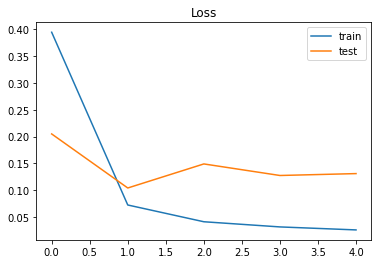

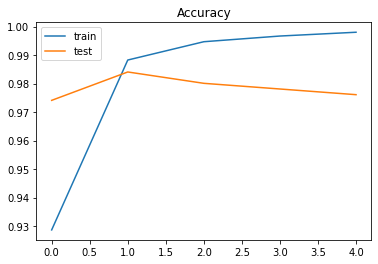

In [49]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

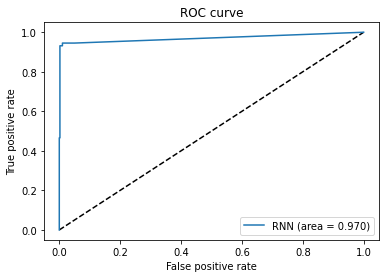

In [50]:
# auc curve
Y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
auc_pred = auc(fpr, tpr)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RNN (area = {:.3f})'.format(auc_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 3.2 CNN

In [51]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
word_index = tokenizer.word_index
top_words = len(word_index)
print('Found %s unique tokens.' % top_words)

X = np.asarray(tokenizer.texts_to_sequences(df['Message'].values))
Y = df['category_val']
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

print(f"X train: {X_train.shape}, Y train: {Y_train.shape}")
print(f"X test: {X_test.shape}, Y test: {Y_test.shape}")

Found 9006 unique tokens.
X train: (5014,), Y train: (5014,)
X test: (558,), Y test: (558,)


In [52]:
# Padding the data samples to a maximum review length in words
max_words = 450
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(MAX_NB_WORDS, 32, input_length=max_words))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 450, 32)           1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 450, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 225, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 250)               1800250   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 251       
Total params: 3,403,605
Trainable params: 3,403,605
Non-trainable params: 0
____________________________________________

In [54]:
# Fitting the data onto model
model.fit(X_train, Y_train, 
          validation_data=(X_test, Y_test), 
          epochs=5, batch_size=128, verbose=2)

# Getting score metrics from our model
scores = model.evaluate(X_test, Y_test, verbose=0)

# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
40/40 - 3s - loss: 0.0394 - accuracy: 0.9902 - val_loss: 0.0473 - val_accuracy: 0.9839
Epoch 2/5
40/40 - 3s - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0446 - val_accuracy: 0.9892
Epoch 3/5
40/40 - 3s - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0431 - val_accuracy: 0.9892
Epoch 4/5
40/40 - 4s - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0447 - val_accuracy: 0.9892
Epoch 5/5
40/40 - 4s - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0483 - val_accuracy: 0.9892
Accuracy: 98.92%


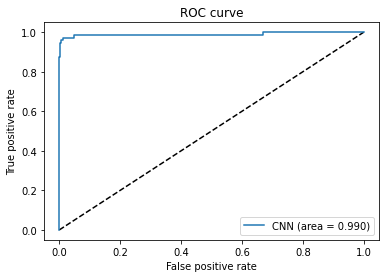

In [55]:
# auc curve
Y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
auc_pred = auc(fpr, tpr)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN (area = {:.3f})'.format(auc_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 3.3 Compare the result

Based on the ROC curve of two models above, we can tell that both of them perform very well. But CNN performs slightly better than RNN